In [1]:
import numpy as np
from mpmath import mp
import h5py
import matplotlib.pyplot as plt

In [2]:
#import MiniPole code
from mini_pole import ESPRIT, MiniPoleRf

# 0. Tools

In [3]:
# coth(x) + 1 for a scalar x
def coth_plus_1_indiv(x):
    assert x != 0 
    if x > 0:
        return 2.0 / (1 - np.exp(-2.0 * x))
    else:
        return 2.0 * np.exp(2.0 * x) / (np.exp(2.0 * x) - 1)

# coth(x) + 1 for a vector x
def coth_plus_1(x):
    return np.vectorize(coth_plus_1_indiv)(x)

In [4]:
# calculate the Green's function from its complex poles
def cal_G(z, Al, xl):
    G_z = 0.0
    for i in range(xl.size):
        G_z += Al[i] / (z - xl[i])
    return G_z

# 1. Unit transform

In [5]:
# constants in standard units
c = 299792458
k_B = 1.380649*10**(-23)
h_bar = 1.054571817 * 10**(-34)

In [6]:
fs_inv_to_cm_inv = 1 / (2.0 * np.pi * c / 10**15 * 100)
cm_inv_to_fs_inv = 1 / fs_inv_to_cm_inv
fs_to_cm = 1.0 / fs_inv_to_cm_inv

# 2. Analytic expressions for sub-Ohmic bath

In [7]:
# all quantities below use fs and fs^-1

In [8]:
s = 0.5
alpha = 1.0
w_c = 50 * cm_inv_to_fs_inv # convert to fs^-1
t_c = 2000
N_e = 5000

T = 50 # in Kelvin
beta_in_fs = h_bar / (k_B * T) * 10**15
beta_in_cm = beta_in_fs * fs_to_cm

In [9]:
# spectral function normalized by w_c
def J_subohmic(w):
    if w >= 0:
        return alpha * (w / w_c) ** s * np.exp(-w / w_c)
    else:
        return -J_subohmic(-w)

In [10]:
# effective spectral function normalized by w_c
def S_subohmic(w):
    return np.vectorize(J_subohmic)(w) * coth_plus_1(0.5 * beta_in_fs * w)

In [11]:
# bath correlation function normalized by w_c^2
from scipy.special import gamma

def C_subohmic_indiv(t):
    return 1.0 / (2.0 * np.pi) * 2.0 * alpha * (1.0 / (w_c * beta_in_fs)) ** (s + 1.0) * gamma(s + 1) * (complex(mp.hurwitz(s + 1, (1 + beta_in_fs * w_c - 1j * w_c * t) / (beta_in_fs * w_c))) + complex(mp.hurwitz(s + 1, (1 + 1j * w_c * t) / (beta_in_fs * w_c))))

def C_subohmic(t):
    return np.vectorize(C_subohmic_indiv)(t)

In [12]:
# calculate the bath correlation function from poles in the lower half-plane
def cal_C(t, Al, xl):
    Ct = 0.0
    for i in range(xl.size):
         Ct -= 1j * Al[i] * np.exp(-1j * xl[i] * t)
    return Ct

# 3. Simultions for 8 poles

In [13]:
M = 8

## (1) AAA

In [14]:
data_aaa = h5py.File("subohmic_50K_AAA.h5", "r")
Al0 = data_aaa["/" + str(M) + "/res_real"][()] + 1j * data_aaa["/" + str(M) +  "/res_imag"][()]
xl0 = data_aaa["/" + str(M) + "/pol_real"][()] + 1j * data_aaa["/" + str(M) +  "/pol_imag"][()]
data_aaa.close()

idx0 = xl0.imag < 0
Al0  = Al0[idx0]
xl0  = xl0[idx0]
assert Al0.size == M and xl0.size == M

## (2) ESPRIT

In [15]:
# input data
t_input  = np.linspace(0, t_c, N_e + 1)
Ct_input = C_subohmic(t_input)

# perform ESPRIT
p1 = ESPRIT(Ct_input, t_input.min(), t_input.max(), M=M)

## (3) MPM

In [16]:
w_max = 0.5
k_max = 1000
err = 1.e-6
# sing_vals is set to [0] because S(w) has a singularity at w = 0
p2 = MiniPoleRf([S_subohmic], interval_type="infinite", wp_max=0.1, sing_vals=[0], err=err, M=M, k_max=k_max)
p3 = MiniPoleRf([S_subohmic], interval_type="finite", w_min=-w_max, w_max=w_max, sing_vals=[0], err=err, M=2*M, k_max=k_max)

In [17]:
# obtain poles in the lower half-plane
idx2 = p2.pole_location.imag < 0
Al2  = p2.pole_weight[idx2][:, 0, 0]
xl2  = p2.pole_location[idx2]

idx3 = p3.pole_location.imag < 0
Al3  = p3.pole_weight[idx3][:, 0, 0]
xl3  = p3.pole_location[idx3]

## (4) Results

In [18]:
#results on sampling points
C_t_e = C_subohmic(t_input)
C_t_r0 = cal_C(t_input, Al0, xl0) / w_c
C_t_r1 = np.squeeze(p1.get_value(t_input))
C_t_r2 = cal_C(t_input, Al2, xl2) / w_c
C_t_r3 = cal_C(t_input, Al3, xl3) / w_c

In [19]:
#results on extended interval
n = 10
t_ext = np.linspace(0, n * t_c, N_e + 1)
C_ext_e = C_subohmic(t_ext)
C_ext_r0 = cal_C(t_ext, Al0, xl0) / w_c
C_ext_r1 = np.squeeze(p1.get_value(t_ext))
C_ext_r2 = cal_C(t_ext, Al2, xl2) / w_c
C_ext_r3 = cal_C(t_ext, Al3, xl3) / w_c

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mini_pole-0.4-py3.10.egg/mini_pole/esprit.py:144: UserWarning: This approximation only has error control for x in [x_min, x_max]!


In [20]:
# obtain poles from ESPRIT

# poles in the lower half-plane
Al1_lower = 1j * p1.omega[:, 0]
xl1_lower = 1j * np.log(p1.gamma) / (p1.x_k[1] - p1.x_k[0])
# poles in the upper half-plane
Al1_upper = 2 * Al1_lower.real - Al1_lower
xl1_upper = np.conjugate(xl1_lower)
# all poles
Al1 = np.concatenate((Al1_lower, Al1_upper))
xl1 = np.concatenate((xl1_lower, xl1_upper))

In [21]:
#results for real frequencies
w = np.linspace(-0.015, 0.015, 100000)
S_w_e  = S_subohmic(w)
S_w_r0 = 2.0 * cal_G(w, Al0, xl0).real
S_w_r1 = cal_G(w, Al1, xl1).real * w_c
S_w_r2 = 2.0 * cal_G(w, Al2, xl2).real
S_w_r3 = 2.0 * cal_G(w, Al3, xl3).real

# 4. Simulations for different $M$

In [22]:
M_list = np.arange(3, 11)

In [23]:
# exact BCF results
n = 10
t_i = np.linspace(0, t_c, N_e + 1)
t_o = np.linspace(t_c, n * t_c, (n - 1) * N_e + 1)

C_i_e = C_subohmic(t_i)
C_o_e = C_subohmic(t_o)

## (1) AAA

In [24]:
err_i_0 = []
err_o_0 = []

for M in M_list:
    data_aaa = h5py.File("subohmic_50K_AAA.h5", "r")
    Al0 = data_aaa["/" + str(M) + "/res_real"][()] + 1j * data_aaa["/" + str(M) +  "/res_imag"][()]
    xl0 = data_aaa["/" + str(M) + "/pol_real"][()] + 1j * data_aaa["/" + str(M) +  "/pol_imag"][()]
    data_aaa.close()
    
    idx0 = xl0.imag < 0
    Al0  = Al0[idx0]
    xl0  = xl0[idx0]
    assert Al0.size == M and xl0.size == M
    
    C_i_r0 = cal_C(t_i, Al0, xl0) / w_c
    C_o_r0 = cal_C(t_o, Al0, xl0) / w_c
    
    dCi0 = np.abs(C_i_r0 - C_i_e) / np.abs(C_i_e[0])
    dCo0 = np.abs(C_o_r0 - C_o_e) / np.abs(C_i_e[0])
    
    err_i_0.append(dCi0.mean())
    err_o_0.append(dCo0.mean())

## (2) ESPRIT

In [25]:
import time

start_time = time.time()

err_i_1 = []
err_o_1 = []

for M in M_list:
    p1 = ESPRIT(Ct_input, t_input.min(), t_input.max(), M=M)
    C_i_r1 = np.squeeze(p1.get_value(t_i))
    C_o_r1 = np.squeeze(p1.get_value(t_o))
    
    dCi1 = np.abs(C_i_r1 - C_i_e) / np.abs(C_i_e[0])
    dCo1 = np.abs(C_o_r1 - C_o_e) / np.abs(C_i_e[0])
    
    err_i_1.append(dCi1.mean())
    err_o_1.append(dCo1.mean())

end_time = time.time()
print(f"Running time: {end_time - start_time:.6f} seconds")

Running time: 120.012079 seconds


## (3) MPM

In [26]:
start_time = time.time()

err_i_2 = []
err_o_2 = []

for M in M_list:
    p2.change_M(M)
    idx2 = p2.pole_location.imag < 0
    Al2  = p2.pole_weight[idx2][:, 0, 0]
    xl2  = p2.pole_location[idx2]
    
    C_i_r2 = cal_C(t_i, Al2, xl2) / w_c
    C_o_r2 = cal_C(t_o, Al2, xl2) / w_c
    
    dCi2 = np.abs(C_i_r2 - C_i_e) / np.abs(C_i_e[0])
    dCo2 = np.abs(C_o_r2 - C_o_e) / np.abs(C_i_e[0])
    
    err_i_2.append(dCi2.mean())
    err_o_2.append(dCo2.mean())

end_time = time.time()
print(f"Running time: {end_time - start_time:.6f} seconds")

Running time: 1.148376 seconds


In [27]:
start_time = time.time()

err_i_3 = []
err_o_3 = []

for M in M_list:
    p3.change_M(2 * M)
    idx3 = p3.pole_location.imag < 0
    Al3  = p3.pole_weight[idx3][:, 0, 0]
    xl3  = p3.pole_location[idx3]
    
    C_i_r3 = cal_C(t_i, Al3, xl3) / w_c
    C_o_r3 = cal_C(t_o, Al3, xl3) / w_c
    
    dCi3 = np.abs(C_i_r3 - C_i_e) / np.abs(C_i_e[0])
    dCo3 = np.abs(C_o_r3 - C_o_e) / np.abs(C_i_e[0])
    
    err_i_3.append(dCi3.mean())
    err_o_3.append(dCo3.mean())

end_time = time.time()
print(f"Running time: {end_time - start_time:.6f} seconds")

Running time: 1.153390 seconds


# 5. Plot

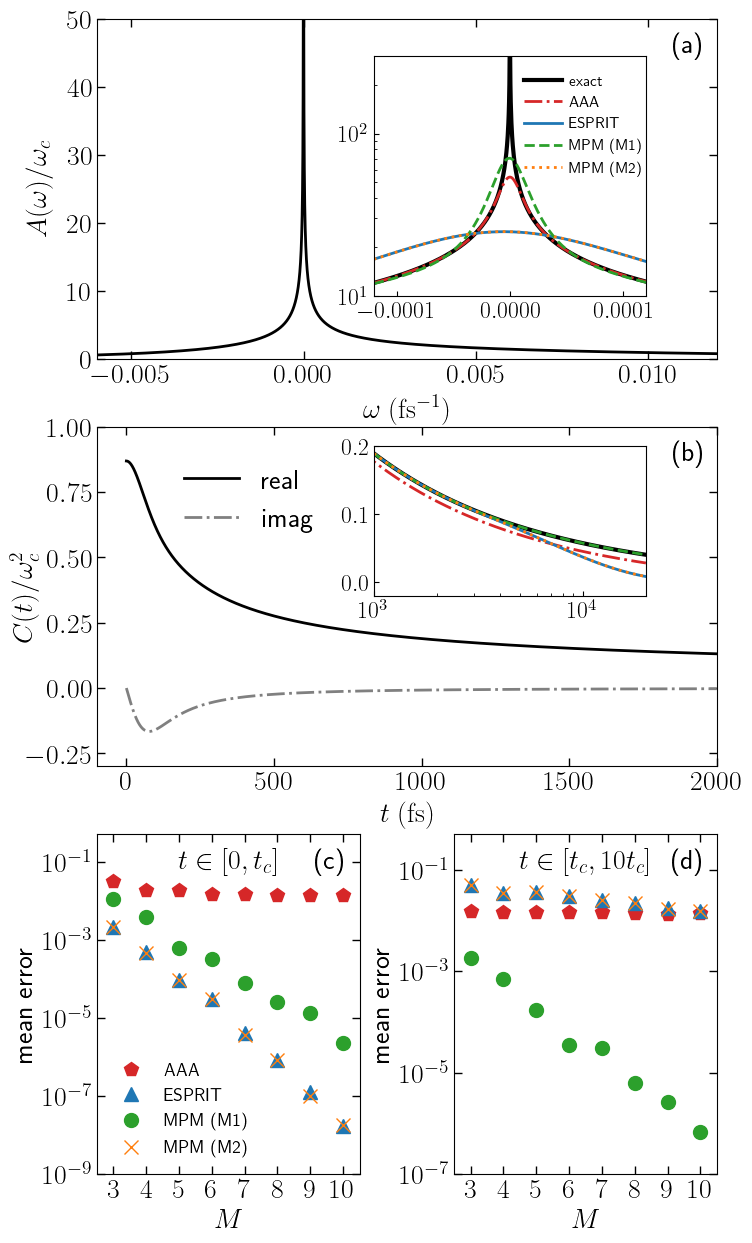

In [28]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator
import matplotlib.ticker as ticker

plt.rcParams.update({
    'text.usetex': True,
    'font.weight': 'bold',  # Makes the font bold
    'axes.labelweight': 'bold',  # Axis labels bold
    'axes.titleweight': 'bold'   # Title bold
})

fontsize = 20
labelsize = 20
linewidth = 2
markersize= 10

major_len = 6
major_wid = 1
minor_len = 3
minor_wid = 1

# Create the figure and subplots
fig = plt.figure(figsize=(8, 15))
gs = fig.add_gridspec(3, 2, wspace=0.36, hspace=0.2)

ax0  = fig.add_subplot(gs[0, :])
ax1  = fig.add_subplot(gs[1, :])
ax20 = fig.add_subplot(gs[2, 0])
ax21 = fig.add_subplot(gs[2, 1])

# Plot data in the subplots
# Subplot (a)
ax0.plot(w, S_w_e, "k", linewidth=linewidth)
ax0.tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
ax0.tick_params(which="major", length=major_len, width=major_wid)
ax0.tick_params(which="minor", length=minor_len, width=minor_wid)
ax0.set_xlim([-0.006, 0.012])
ax0.set_ylim([0, 50])
ax0.set_xlabel(r'$\omega\;({\rm fs}^{-1})$', fontsize=labelsize)
ax0.set_ylabel(r'$A(\omega)/\omega_c$', fontsize=labelsize, labelpad=10)
ax0.text(0.93, 0.9, '(a)', transform=ax0.transAxes, fontsize=fontsize)

#inset of subfigure 1
axins1 = inset_axes(ax0, width="100%", height="100%", bbox_to_anchor=(.48, .7, .34, .16), bbox_transform=ax0.figure.transFigure)#, bbox_transform=ax.transAxes)
axins1.semilogy(w, S_w_e , "k-" , linewidth=linewidth+1, label="exact")
axins1.semilogy(w, S_w_r0, "-." , color="tab:red"   , linewidth=linewidth, label="AAA")
axins1.semilogy(w, S_w_r1, "-"  , color="tab:blue"  , linewidth=linewidth, label="ESPRIT")
axins1.semilogy(w, S_w_r2, "--" , color="tab:green" , linewidth=linewidth, label="MPM (M1)")
axins1.semilogy(w, S_w_r3, ":"  , color="tab:orange", linewidth=linewidth, label="MPM (M2)")
axins1.legend(fontsize=fontsize-9, frameon=False, handlelength=2.5, loc="upper left", bbox_to_anchor=(0.50, 0.98), handletextpad=0.5)
axins1.set_xticks([-1e-4, 0, 1e-4])
axins1.set_yticks([1e1, 1e2])
axins1.set_xlim([-1.2e-4, 1.2e-4])
axins1.set_ylim([1e1, 3e2])
axins1.tick_params(axis="both", which="both", direction="in", labelsize=labelsize-3)

# Subplot (b)
ax1.plot(t_input, C_t_e.real, "k-" , linewidth=linewidth, label="real")
ax1.plot(t_input, C_t_e.imag, "-.", color = "gray", linewidth=linewidth, label="imag")
ax1.legend(fontsize=fontsize, frameon=False, loc="upper left", bbox_to_anchor=(0.1, 0.95))#, loc=2)
ax1.tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
ax1.tick_params(which="major", length=major_len, width=major_wid)
ax1.tick_params(which="minor", length=minor_len, width=minor_wid)
ax1.set_xlim([-100, 2000])
ax1.set_ylim([-0.3, 1])
ax1.set_xlabel(r'$t\;({\rm fs})$', fontsize=labelsize)
ax1.set_ylabel(r'$C(t)/\omega_c^2$', fontsize=labelsize, labelpad=-10)
ax1.text(0.93, 0.9, '(b)', transform=ax1.transAxes, fontsize=fontsize)

#inset of subfigure 2
axins2 = inset_axes(ax1, width="100%", height="100%", bbox_to_anchor=(.48, .5, .34, .1), bbox_transform=ax1.figure.transFigure)#, bbox_transform=ax.transAxes)
axins2.semilogx(t_ext, C_ext_e.real , "k-" , linewidth=linewidth+1, label="exact")
axins2.semilogx(t_ext, C_ext_r0.real, "-." , color="tab:red"   , linewidth=linewidth, label="AAA")
axins2.semilogx(t_ext, C_ext_r1.real, "-"  , color="tab:blue"  , linewidth=linewidth, label="ESPRIT")
axins2.semilogx(t_ext, C_ext_r2.real, "--" , color="tab:green" , linewidth=linewidth, label="MPM 1")
axins2.semilogx(t_ext, C_ext_r3.real, ":"  , color="tab:orange", linewidth=linewidth, label="MPM 2")
axins2.set_xlim([1e3, 2e4])
axins2.set_ylim([-0.02, 0.2])
axins2.tick_params(axis="both", which="both", direction="in", labelsize=labelsize-3)

# Subplot (c)
ax20.semilogy(M_list, err_i_0, "p", color="tab:red"   , markersize=markersize, label="AAA")
ax20.semilogy(M_list, err_i_1, "^", color="tab:blue"  , markersize=markersize, label="ESPRIT")
ax20.semilogy(M_list, err_i_2, "o", color="tab:green" , markersize=markersize, label="MPM (M1)")
ax20.semilogy(M_list, err_i_3, "x", color="tab:orange", markersize=markersize, label="MPM (M2)")
ax20.legend(fontsize=fontsize-7, frameon=False, loc=3)
ax20.tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
ax20.tick_params(which="major", length=major_len, width=major_wid)
ax20.tick_params(which="minor", length=minor_len, width=minor_wid)
ax20.set_xticks([3, 4, 5, 6, 7, 8, 9, 10])
ax20.set_yticks([1.e-9, 1e-7, 1.e-5, 1e-3, 1.e-1])
ax20.yaxis.set_minor_locator(plt.NullLocator())
ax20.set_xlim([2.5, 10.5])
ax20.set_ylim([1.e-9, 5.e-1])
ax20.set_xlabel(r'$M$', fontsize=labelsize)
ax20.set_ylabel(r'mean error', fontsize=labelsize)
ax20.text(0.83, 0.9, '(c)', transform=ax20.transAxes, fontsize=fontsize)
ax20.text(0.5, 0.9, r'$t\in[0, t_c]$', transform=ax20.transAxes, fontsize=fontsize, ha="center")

# Subplot (d)
ax21.semilogy(M_list, err_o_0, "p", color="tab:red"   , markersize=markersize, label="AAA")
ax21.semilogy(M_list, err_o_1, "^", color="tab:blue"  , markersize=markersize, label="ESPRIT")
ax21.semilogy(M_list, err_o_2, "o", color="tab:green" , markersize=markersize, label="MPM 1")
ax21.semilogy(M_list, err_o_3, "x", color="tab:orange", markersize=markersize, label="MPM 2")
ax21.tick_params(axis="both", which="both", direction="in", pad=3, labelsize=labelsize, right=True, top=True)
ax21.tick_params(which="major", length=major_len, width=major_wid)
ax21.tick_params(which="minor", length=minor_len, width=minor_wid)
ax21.set_xticks([3, 4, 5, 6, 7, 8, 9, 10])
ax21.set_yticks([1.e-7, 1.e-5, 1.e-3, 1.e-1])
ax21.yaxis.set_minor_locator(plt.NullLocator())
ax21.set_xlim([2.5, 10.5])
ax21.set_ylim([1.e-7, 5.e-1])
ax21.set_xlabel(r'$M$', fontsize=labelsize)
ax21.set_ylabel(r'mean error', fontsize=labelsize)
ax21.text(0.83, 0.9, '(d)', transform=ax21.transAxes, fontsize=fontsize)
ax21.text(0.5, 0.9, r'$t\in[t_c, 10t_c]$', transform=ax21.transAxes, fontsize=fontsize, ha="center")

plt.show()